In [1]:
print('   ')
print('                                                  ####################################################################')
print('                                                  #######-------->>>> ***++++  START  +++++*** <<<<-----------########')
print('                                                  ####################################################################')
print('   ')


import time
import os
import numpy as np
import pdb
import librosa
from scipy.signal import stft
import librosa.display
#from metrics import mse
import tensorflow as tf
from keras.optimizers import Adam
from make_network.system import get_model
from make_network.losses import MEL_MR_L1_Loss
from make_network.load_training_data import get_train_val_Data, get_input_shape
from make_network.callbacks import LRTensorBoard, get_run_logdir, SaveMelSpectrogramCallback
from helpers.utils import get_file_paths
#from make_network.callbacks import PrintControllerOutputCallback
import own_config as config
import keras_tuner as kt


np.random.seed(config.config['random_seed'])

# Load file paths 
x_dir = './datasets/test/dirty'
y_dir = './datasets/test/clean'

print(x_dir)
# Get Train Data

   
                                                  ####################################################################
                                                  #######-------->>>> ***++++  START  +++++*** <<<<-----------########
                                                  ####################################################################
   
./datasets/test/dirty


In [2]:
train_dataset, val_dataset, steps_per_epoch, validation_steps = get_train_val_Data(x_dir, y_dir, config.config)

total_size = len(get_file_paths(x_dir)*2)
train_size = int(total_size * config.config['train_ratio'])
test_size = int(total_size * config.config['test_ratio'])
val_size = total_size - train_size - test_size

input_shape = get_input_shape(train_dataset)


#with strategy.scope():
# Setting up the learning rate scheduler
initial_learning_rate = config.config['lr']
lr=initial_learning_rate
if (config.config['lr_scheduler'] == "True"):
    lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=steps_per_epoch/10,
    decay_rate=config.config['lr_decay'],
    staircase=True)

model, _ = get_model(config.config, input_shape)  

# Applying the learning rate scheduler to the Adam optimizer 
if(config.config['system'] == "Apple_Silicon"): 
    if(config.config['optimizer'] == "adam"):optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    if(config.config['optimizer'] == "sdg"):optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr)
else:
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

<--- x_files --->
['./datasets/test/dirty/1115635_telephone_IR.wav', './datasets/test/dirty/1331235_bright_IR.wav', './datasets/test/dirty/1363077_neutral_IR.wav', './datasets/test/dirty/585838_neutral_IR.wav', './datasets/test/dirty/582670_bright_IR.wav', './datasets/test/dirty/1384401_broadcast_IR.wav', './datasets/test/dirty/1173421_telephone_IR.wav', './datasets/test/dirty/729301_broadcast_IR.wav', './datasets/test/dirty/1197770_telephone_IR.wav', './datasets/test/dirty/1198542_broadcast_IR.wav']


2024-03-23 15:08:28.380583: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-03-23 15:08:28.380645: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-23 15:08:28.380650: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-23 15:08:28.380924: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-23 15:08:28.381355: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Steps per epoch: 45, Validation steps: 5
Total size: 3650, Train size: 2920, Validation size: 365


2024-03-23 15:08:29.454679: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-03-23 15:08:29.466765: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-03-23 15:08:29.475161: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. I

x_train shape: (64, 60000)
y_train shape: (64, 60000)
y_train_targets shape: (64, 60000)
<-> printing input shape here <->
(64, 60000)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_data_channel (InputL  [(None, 60000)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 referenz_data_channel (Inp  [(None, 60000)]              0         []                            
 utLayer)                                                                                         
                                                                                                  
 MelLayer_in (MelSpectrogra  (None, 256, 256, 1)        

In [4]:
!pip install graphviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.4 MB/s eta 0:00:00


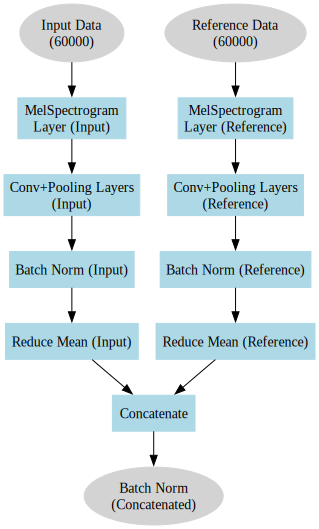

In [22]:
from graphviz import Digraph

dot = Digraph(comment='Encoder')

# Set graph attributes
dot.attr(rankdir='TB', size='20')

# Define the nodes, using ellipses for inputs and outputs for stylistic choice
dot.attr('node', shape='ellipse', style='filled', color='lightgrey')

dot.node('A', 'Input Data\n(60000)')
dot.node('B', 'Reference Data\n(60000)')

dot.attr('node', shape='rectangle', style='filled', color='lightblue')

dot.node('C', 'MelSpectrogram\nLayer (Input)')
dot.node('D', 'MelSpectrogram\nLayer (Reference)')
dot.node('E', 'Conv+Pooling Layers\n(Input)')
dot.node('F', 'Conv+Pooling Layers\n(Reference)')
dot.node('G', 'Batch Norm (Input)')
dot.node('H', 'Batch Norm (Reference)')
dot.node('I', 'Reduce Mean (Input)')
dot.node('J', 'Reduce Mean (Reference)')
dot.node('K', 'Concatenate')

dot.attr('node', shape='ellipse', style='filled', color='lightgrey')

dot.node('L', 'Batch Norm\n(Concatenated)')

# Connect nodes with edges
dot.edges(['AC', 'BD', 'CE', 'DF', 'EG', 'FH', 'GI', 'HJ', 'IK', 'JK', 'KL'])

# Render the graph into the notebook
dot.format = 'png'
dot.render('encoder', view=False)  # Save and render the graph to a file
dot  # Display the graph


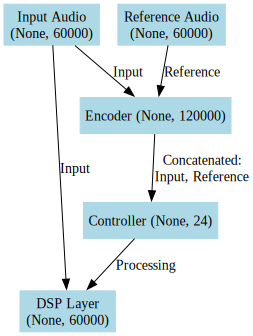

In [29]:
# Create a Digraph object
dot = Digraph(comment='Full Model')

# Define global attributes
dot.attr(rankdir='TB', size='50')
dot.attr('node', shape='box', style='filled', color='lightblue')

# Define nodes
nodes = {
    'A': 'Input Audio\n(None, 60000)',
    'B': 'Reference Audio\n(None, 60000)',
    'C': 'Encoder (None, 120000)',
    'D': 'Controller (None, 24)',
    'E': 'DSP Layer\n(None, 60000)'
}

# Add nodes to the graph
for node, label in nodes.items():
    dot.node(node, label)

# Define edges
edges = [
    ('A', 'C', 'Input'),
    ('B', 'C', 'Reference'),
    ('C', 'D', 'Concatenated: \n Input, Reference'),
    ('A', 'E', 'Input'),
    ('D', 'E', 'Processing')
]

# Add edges to the graph
for src, dst, label in edges:
    dot.edge(src, dst, label=label)

# Set output format and render the graph
dot.format = 'png'
dot.render('full_model_architecture', view=False)  # Save to a file
dot

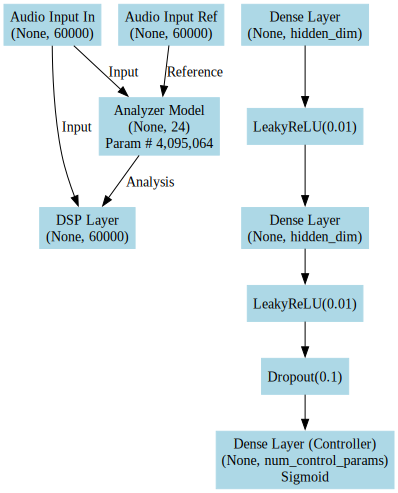

In [9]:

dot = Digraph(comment='Controller')

# Node styles
dot.attr('node', shape='box', style='filled', color='lightblue')

# Nodes for the full model for context
dot.node('A', 'Audio Input In\n(None, 60000)')
dot.node('B', 'Audio Input Ref\n(None, 60000)')
dot.node('C', 'Analyzer Model\n(None, 24)\nParam # 4,095,064')
dot.node('D', 'DSP Layer\n(None, 60000)')

# Controller layer nodes
dot.node('E', 'Dense Layer\n(None, hidden_dim)')
dot.node('F', 'LeakyReLU(0.01)')
dot.node('G', 'Dense Layer\n(None, hidden_dim)')
dot.node('H', 'LeakyReLU(0.01)')
dot.node('I', 'Dropout(0.1)')
dot.node('J', 'Dense Layer (Controller)\n(None, num_control_params)\nSigmoid')

# Edges for the full model
dot.edge('A', 'C', label='Input')
dot.edge('B', 'C', label='Reference')
dot.edge('A', 'D', label='Input')
dot.edge('C', 'D', label='Analysis')

# Edges for the controller layer
dot.edges([('E', 'F'), ('F', 'G'), ('G', 'H'), ('H', 'I'), ('I', 'J')])

# Optionally, if the controller layer is directly connected to parts of the model:
# dot.edge('D', 'E', label='Input to Controller')
# Adjust labels and connections based on your model's specific architecture

# Render and display
dot.format = 'png'
dot.render('network_with_controller', view=False)  # Save to a file
dot  # Display the diagram
